# Introduction

The learning to smell challenge is all about using machine learning to learn attributes of compounds in order to predict what they might smell like. The dataset provided consists of SMILES sentences and smell labels.

In this notebook I show you how to use SMILES vectors created with the SMILESVEC package to train a fully-connected neural network using the Keras library.
SMILESVec package:
https://github.com/hkmztrk/SMILESVecProteinRepresentation

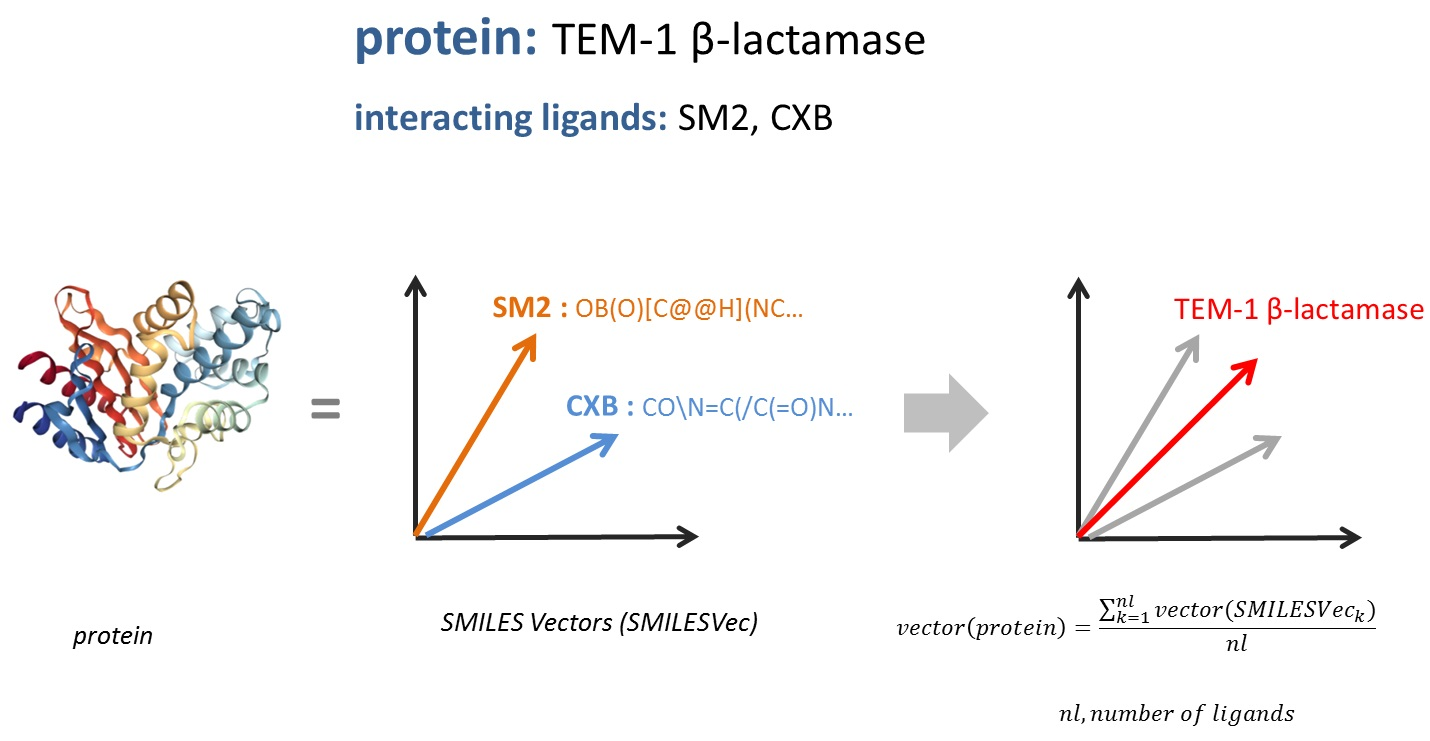

# Loading data files and setting up the environment


In [1]:
!gdown --id 1N6MRQR-N-rRag84uH11GxQDGPm56ZTzj

Downloading...
From: https://drive.google.com/uc?id=1N6MRQR-N-rRag84uH11GxQDGPm56ZTzj
To: /content/smell_colab.zip
3.17MB [00:00, 104MB/s]


In [2]:
!unzip smell_colab.zip

Archive:  smell_colab.zip
  inflating: smiles.vec              
  inflating: smiles_test.txt         
  inflating: smiles_train.txt        
  inflating: smiles_train.vec        
  inflating: vocabulary.txt          
  inflating: y_train.csv             


In [3]:
!ls

sample_data	 smiles_test.txt   smiles_train.vec  vocabulary.txt
smell_colab.zip  smiles_train.txt  smiles.vec	     y_train.csv


In [4]:
import pickle
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import csv
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow import keras as K
import sklearn
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint

In [5]:
TRAIN_PICKLE_DIR = "/content/smiles_train.vec"
TEST_PICKLE_DIR = "/content/smiles.vec"
VOCABULARY_DIR = '/content/vocabulary.txt'
Y_TRAIN_DIR = '/content/y_train.csv'
TRAIN_SMILES = '/content/smiles_train.txt'
TEST_SMILES = '/content/smiles_test.txt'

# Create functions and load the data

In [6]:
def load_data(pickle_dir):
    SMILESVec = pickle.load(open(pickle_dir, "rb"))
    SMILES_array = np.asarray(SMILESVec)
    SMILES_array = SMILES_array[:-1]
    return SMILES_array

def dictionarize_vocabulary():
    with open(VOCABULARY_DIR, newline='') as f:
        reader = csv.reader(f)
        vocabulary = list(reader)
        vocabulary_dict = {}
    for i in range(len(vocabulary)):
        vocabulary_dict[vocabulary[i][0]] = i
    return vocabulary_dict

def get_words():
    with open(Y_TRAIN_DIR, newline='') as f:
        reader = csv.reader(f)
        words = list(reader)
        words = words[1:]
    return words
    
def split_words(words):
    y_train = []
    for molecule in words:
        linelist = []
        line = molecule[0].split(',')
        y_train.append(line)
        y_train = [tuple(x) for x in y_train]
    return y_train

def normalize_labels(labels):
    normalized_labels = []
    for label in labels:
        total = np.sum(label)
        normalized_label = label / total
        normalized_labels.append(normalized_label)
    return np.asarray(normalized_labels)

Load the training and test data

In [7]:
X_vector = load_data(TRAIN_PICKLE_DIR)
x_test_vector = load_data(TEST_PICKLE_DIR)

Load the targets, split the data and normalize


In [8]:
vocabulary_dictionary = dictionarize_vocabulary()
reversed_vocabulary_dictionary = {value : key for (key, value) in vocabulary_dictionary.items()}
words = get_words()
Y = split_words(words)
one_hot = MultiLabelBinarizer()
Y = np.asarray(Y)
Y = one_hot.fit_transform(Y)
x_train_vector, x_val_vector, y_train, y_val = train_test_split(X_vector, Y, test_size = 0.2, random_state = 1996)
y_train_normalized = normalize_labels(y_train)
y_val_normalized = normalize_labels(y_val)
Y_normalized = normalize_labels(Y)

In [9]:
print(x_train_vector.shape) ## vector of 100
print(y_train.shape) ## 109 0's or 1's

(3452, 100)
(3452, 109)


In [10]:
print(reversed_vocabulary_dictionary[0], reversed_vocabulary_dictionary[1]) ## what kind of classes are we looking at?

alcoholic aldehydic


# Building the model and create top-5 predictions

Define the functions to build the model

In [11]:
def build_model():
    model = Sequential()
    model.add(Dense(124, input_dim=(100), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(109, activation='sigmoid'))
    model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Train the model until validation loss gets worse

In [12]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5) ## Stop training when val loss gets worse
checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True, verbose=0) ## Only keep the weights of the best epoch

In [13]:
model = build_model() ## Wrapping the model in a function allows you to re-initialize the weights

In [14]:
model.summary() ## Let's see what the model looks like

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 124)               12524     
_________________________________________________________________
dropout (Dropout)            (None, 124)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 109)               13625     
Total params: 26,149
Trainable params: 26,149
Non-trainable params: 0
_________________________________________________________________


Let's start training!

In [15]:
model.fit(x_train_vector, y_train_normalized, validation_data=(x_val_vector, y_val_normalized), epochs = 1000, verbose = 1, callbacks=[es_callback, checkpoint])

Epoch 1/1000
108/108 [==============================] - 0s 4ms/step - loss: 4.3924 - accuracy: 0.0487 - val_loss: 4.1738 - val_accuracy: 0.0613
Epoch 2/1000
108/108 [==============================] - 0s 2ms/step - loss: 4.1183 - accuracy: 0.0736 - val_loss: 4.0540 - val_accuracy: 0.0706
Epoch 3/1000
108/108 [==============================] - 0s 2ms/step - loss: 4.0004 - accuracy: 0.0765 - val_loss: 3.9840 - val_accuracy: 0.0683
Epoch 4/1000
108/108 [==============================] - 0s 2ms/step - loss: 3.9285 - accuracy: 0.0768 - val_loss: 3.9289 - val_accuracy: 0.0660
Epoch 5/1000
108/108 [==============================] - 0s 2ms/step - loss: 3.8691 - accuracy: 0.0811 - val_loss: 3.8929 - val_accuracy: 0.0787
Epoch 6/1000
108/108 [==============================] - 0s 2ms/step - loss: 3.8306 - accuracy: 0.0826 - val_loss: 3.8580 - val_accuracy: 0.0799
Epoch 7/1000
108/108 [==============================] - 0s 2ms/step - loss: 3.7847 - accuracy: 0.0808 - val_loss: 3.8385 - val_accuracy:

Now we can create a prediction vector for every value in the test set

In [16]:
preds = model.predict(x_test_vector)

Keep the top 5 predictions and turn them back into words using the reversed vocabulary dictionary

In [17]:
top_5_preds = []
for pred in preds:
  top_values_index = sorted(range(len(pred)), key=lambda i: pred[i])[-5:] ## sort to only keep the top 5
  top_values_words = []
  for i in range(5):
    top_values_words.append(reversed_vocabulary_dictionary[top_values_index[i]]) ## look up the numbers in the dictionary
  top_5_preds.append(top_values_words)

In [18]:
print(top_5_preds[0:10])

[['coniferous', 'cedar', 'resinous', 'woody', 'camphor'], ['fruity', 'woody', 'cooling', 'herbal', 'mint'], ['fresh', 'floral', 'herbal', 'fruity', 'woody'], ['fresh', 'apple', 'banana', 'odorless', 'fruity'], ['woody', 'citrus', 'fruity', 'rose', 'floral'], ['waxy', 'odorless', 'fatty', 'fruity', 'oily'], ['floral', 'sweet', 'phenolic', 'vanilla', 'spicy'], ['earthy', 'resinous', 'balsamic', 'woody', 'camphor'], ['green', 'meat', 'vegetable', 'sulfuric', 'alliaceous'], ['woody', 'herbal', 'floral', 'fresh', 'fruity']]


If you have any feedback or questions, feel free to reach out on the discussion board! Always happy to help